In [1]:
import pandas as pd
import numpy as np

# Ejercicio 1

Pensamos en usar 20% de test para tener mas confianza en los resultados de nuestros modelos. 10% nos parecio muy bajo (50 datos).

Vamos a usar K-Fold para validar el modelo con el fine-tuning.

(?) usar stratified en test

In [2]:
datos = pd.read_csv("datos/data.csv")
datos = datos.sample(frac=1).reset_index(drop=True) # Permuto las filas al azar x si estaban ordenadas

y = datos['target']
X = datos.iloc[:, :-1]

In [3]:
def desarrollo_evaluacion(X, y, prop_train):
    return X[:int(len(X)*prop_train)], y[:int(len(X)*prop_train)], X[int(len(X)*prop_train):], y[int(len(X)*prop_train):]

In [4]:
X_train, y_train, X_test, y_test = desarrollo_evaluacion(X, y, 0.8)

# Ejercicio 2

In [5]:
from sklearn import tree, model_selection
from sklearn import metrics

In [6]:
arbol = tree.DecisionTreeClassifier(max_depth=3)
arbol.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

(!) average_precision es ~AUPRC

In [7]:
metricas = ['accuracy', 'roc_auc', 'average_precision']
scores = model_selection.cross_validate(arbol, X_train, y_train, cv = 5, scoring = metricas, return_train_score=True, return_estimator=True, return_indices=True)

In [8]:
for metrica in list(scores.keys())[4:]:
    scores[metrica] = {'permutacion': scores[metrica], 'promedio': np.mean(scores[metrica])}

scores

{'fit_time': array([0.02212834, 0.02018666, 0.01843214, 0.0179553 , 0.01763773]),
 'score_time': array([0.00828433, 0.0057807 , 0.00582671, 0.00555587, 0.00427771]),
 'estimator': [DecisionTreeClassifier(max_depth=3),
  DecisionTreeClassifier(max_depth=3),
  DecisionTreeClassifier(max_depth=3),
  DecisionTreeClassifier(max_depth=3),
  DecisionTreeClassifier(max_depth=3)],
 'indices': {'train': (array([ 76,  80,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
           93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
          106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
          119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,
          132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144,
          145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157,
          158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170,
          171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
     

(?) cross_val_predict

In [9]:
pred_folds = np.array([])
real_folds = np.array([])
for i in range(5):
    pred_folds = np.concatenate((pred_folds, scores['estimator'][i].predict(X_train.iloc[scores['indices']['test'][i]])))
    real_folds = np.concatenate((real_folds, y_train[scores['indices']['test'][i]]))

In [10]:
global_scores = {'accuracy': metrics.accuracy_score(real_folds, pred_folds),
                 'AUPRC': metrics.average_precision_score(real_folds, pred_folds),
                 'AUCROC': metrics.roc_auc_score(real_folds, pred_folds)}
global_scores

{'accuracy': 0.67, 'AUPRC': 0.38378251821019765, 'AUCROC': 0.6143057503506312}

In [11]:
grilla = model_selection.ParameterGrid({'max_depth': [3, 5, None], 'criterion': ['gini', 'entropy']})
scores_grilla = []

for params in grilla:
    arbol = tree.DecisionTreeClassifier(**params)
    scores_grilla += [model_selection.cross_validate(arbol, X_train, y_train, cv=5, return_train_score=True)]
    scores_grilla[-1]['promedio_test'] = np.mean(scores_grilla[-1]['test_score'])
    scores_grilla[-1]['promedio_train'] = np.mean(scores_grilla[-1]['train_score'])

In [12]:
[param for param in grilla]

[{'criterion': 'gini', 'max_depth': 3},
 {'criterion': 'gini', 'max_depth': 5},
 {'criterion': 'gini', 'max_depth': None},
 {'criterion': 'entropy', 'max_depth': 3},
 {'criterion': 'entropy', 'max_depth': 5},
 {'criterion': 'entropy', 'max_depth': None}]

In [13]:
scores_grilla

[{'fit_time': array([0.01957273, 0.018399  , 0.0190537 , 0.0183301 , 0.01817536]),
  'score_time': array([0.00205445, 0.00204206, 0.0017643 , 0.00190902, 0.00168395]),
  'test_score': array([0.625 , 0.575 , 0.6875, 0.725 , 0.7375]),
  'train_score': array([0.80625 , 0.825   , 0.834375, 0.828125, 0.846875]),
  'promedio_test': 0.6699999999999999,
  'promedio_train': 0.828125},
 {'fit_time': array([0.02724242, 0.02655435, 0.02691126, 0.02618003, 0.02606535]),
  'score_time': array([0.00177813, 0.00191021, 0.00171518, 0.00173092, 0.00180197]),
  'test_score': array([0.6375, 0.6   , 0.6875, 0.65  , 0.725 ]),
  'train_score': array([0.95    , 0.9625  , 0.96875 , 0.975   , 0.953125]),
  'promedio_test': 0.6599999999999999,
  'promedio_train': 0.961875},
 {'fit_time': array([0.03219914, 0.04238844, 0.03493524, 0.02925205, 0.03686285]),
  'score_time': array([0.00183439, 0.00172019, 0.00180387, 0.00183511, 0.00178432]),
  'test_score': array([0.6125, 0.575 , 0.65  , 0.6125, 0.7   ]),
  'train_

(!) faltan conclusiones

- los ultimos dan 1 porque tienen altura maxima inf
- decir algo de entropy vs. gini

# Ejercicio 3

In [14]:
from sklearn import neighbors, svm, discriminant_analysis, naive_bayes

In [15]:
tree_params = {'max_depth': [i for i in range(20)], 'criterion': ['gini', 'entropy', 'log_loss'], 'max_features': ['sqrt', 'log2']}
knn_params = {'n_neighbors': [i for i in range(1, 20)], 'metric': ['l1', 'l2', 'cosine']}
svm_params = {'C': np.linspace(1, 10, 20), 'tol': [10 ** -i for i in range(1, 6)], 'kernel': ['linear', 'rbf', 'polynomial']}
lda_params = {'solver': ['lsqr', 'eigen'], 'shrinkage': [None, 'auto', 0.1, 0.5, 1.0]}
naive_params = {'priors': [[i, 1-i] for i in np.linspace(0, 1, 100)]}

In [16]:
modelos = {
    tree.DecisionTreeClassifier: tree_params,
    neighbors.KNeighborsClassifier: knn_params,
    svm.SVC: svm_params,
    discriminant_analysis.LinearDiscriminantAnalysis: lda_params,
    naive_bayes.GaussianNB: naive_params
}

results = {}
mejores = []

for modelo, params in modelos.items():
    search = model_selection.RandomizedSearchCV(estimator=modelo(),
                                       param_distributions=params,
                                       scoring='roc_auc')
    search.fit(X_train, y_train)
    results[modelo] = search.cv_results_
    mejores.append(search.best_estimator_)

/home/godo/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
10 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/home/godo/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/godo/.local/lib/python3.10/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/home/godo/.local/lib/python3.10/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/home/godo/.local/lib/pytho

In [17]:
for modelo in modelos.keys():
    print(modelo, results[modelo]['mean_test_score'])

<class 'sklearn.tree._classes.DecisionTreeClassifier'> [       nan 0.56078923 0.58291558 0.49861396        nan 0.563027
 0.56010606 0.59768831 0.5832651  0.53438745]
<class 'sklearn.neighbors._classification.KNeighborsClassifier'> [0.73616012 0.85813122 0.75875925 0.8337375  0.83658669 0.72797835
 0.78618187 0.82527549 0.82553285 0.82142489]
<class 'sklearn.svm._classes.SVC'> [0.78568669 0.78641732 0.78554123 0.78568669        nan        nan
 0.78554123        nan        nan 0.89513203]
<class 'sklearn.discriminant_analysis.LinearDiscriminantAnalysis'> [0.75401786        nan 0.84129156 0.84129156 0.86221017 0.86221017
 0.86808203 0.86808203 0.7749566  0.7749566 ]
<class 'sklearn.naive_bayes.GaussianNB'> [0.79972511 0.79972511 0.79972511 0.79972511 0.79972511 0.79972511
 0.79972511 0.79972511 0.79972511 0.79972511]


In [18]:
for modelo in mejores:
    print(modelo)

DecisionTreeClassifier(criterion='entropy', max_depth=11, max_features='sqrt')
KNeighborsClassifier(metric='l1', n_neighbors=10)
SVC(C=9.052631578947368, tol=1e-05)
LinearDiscriminantAnalysis(shrinkage=0.5, solver='lsqr')
GaussianNB(priors=[0.8787878787878789, 0.1212121212121211])


# Ejercicio 4

Arbol de decision, LDA, SVM

In [19]:
import matplotlib.pyplot as plt
from sklearn.model_selection import ValidationCurveDisplay

Text(0.5, 1.0, 'Arbol de decision')

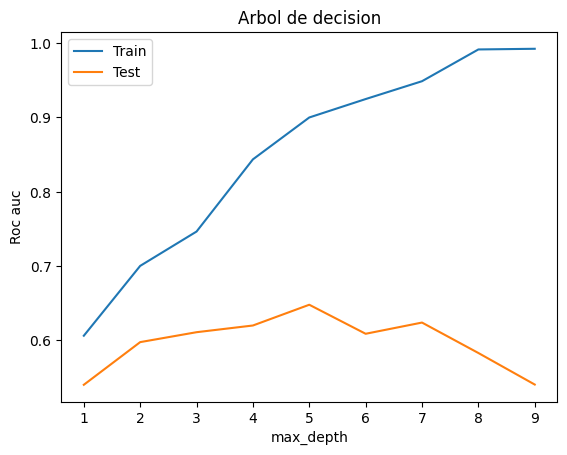

In [36]:
ValidationCurveDisplay.from_estimator(mejores[0], X_train, y_train, param_name='max_depth', param_range=[i for i in range(10)], std_display_style=None, scoring='roc_auc')
plt.title('Arbol de decision')

Text(0.5, 1.0, 'SVM')

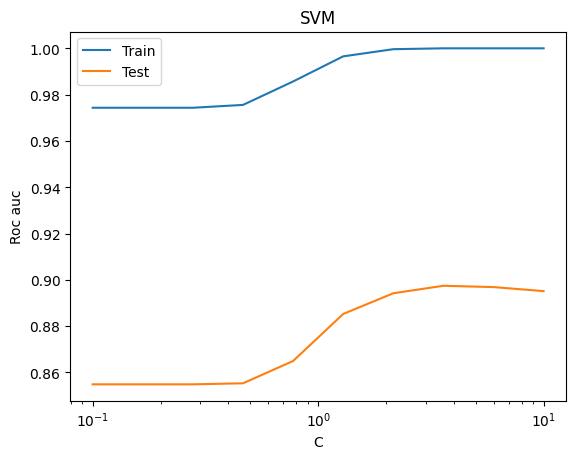

In [58]:
ValidationCurveDisplay.from_estimator(mejores[2], X_train, y_train, param_name='C', param_range=np.logspace(-1, 1, 10), std_display_style=None, scoring='roc_auc')
plt.title('SVM')

In [22]:
from sklearn.model_selection import LearningCurveDisplay

In [ ]:
# Usamos siempre el mismo conjunto de validacion (el ultimo 20%, porque permutamos los datos)
train_test_indices = [([i for i in range(320)], [i for i in range(320, 400)])]

/home/godo/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/godo/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/godo/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/godo/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 345, in _score
    y_pred = method_caller(
  File "/home/godo/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
  File "/home/godo/.local/lib/python3.10/site-packages/sklearn/utils/_response.py", line 213, in _get_resp

Text(0.5, 1.0, 'Arbol de decision')

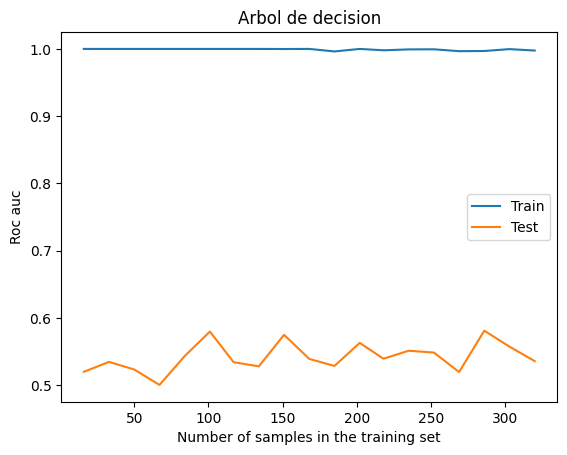

In [39]:
LearningCurveDisplay.from_estimator(mejores[0], X_train, y_train, std_display_style=None, train_sizes = np.linspace(0.00001, 1, 20), scoring='roc_auc', cv=train_test_indices)
plt.title('Arbol de decision')

/home/godo/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
5 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/home/godo/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/godo/.local/lib/python3.10/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/godo/.local/lib/python3.10/site-packages/sklearn/svm/_base.py", line 199, in fit
    y = self._validate_targets(y)
  File "/home/godo/.local/lib

Text(0.5, 1.0, 'SVM')

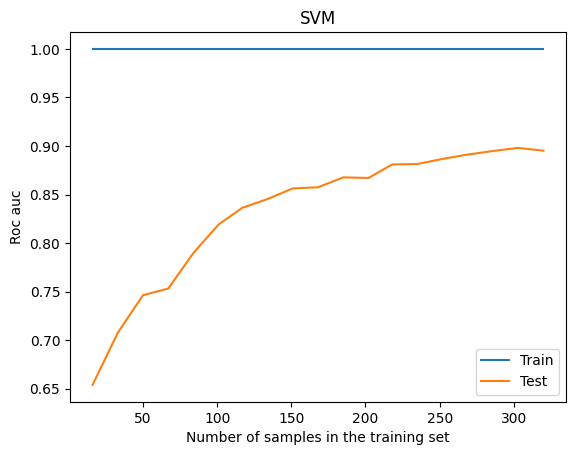

In [40]:
LearningCurveDisplay.from_estimator(mejores[2], X_train, y_train, std_display_style=None, train_sizes = np.linspace(0.00001, 1, 20), scoring='roc_auc', cv=train_test_indices)
plt.title('SVM')

/home/godo/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
5 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/home/godo/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/godo/.local/lib/python3.10/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/godo/.local/lib/python3.10/site-packages/sklearn/discriminant_analysis.py", line 581, in fit
    X, y = self._validate_data(
  File "/home/godo/

Text(0.5, 1.0, 'LDA')

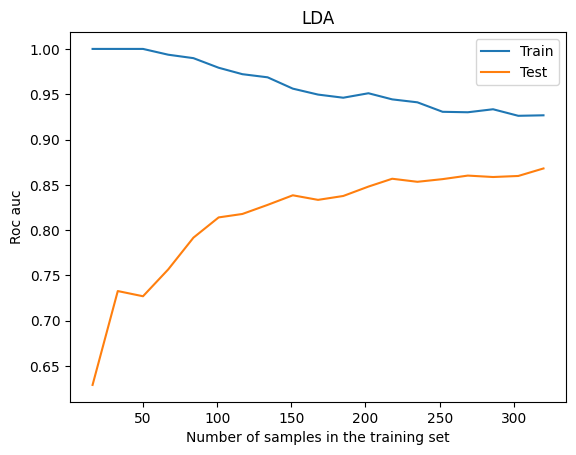

In [42]:
LearningCurveDisplay.from_estimator(mejores[3], X_train, y_train, std_display_style=None, train_sizes = np.linspace(0.00001, 1, 20), scoring='roc_auc', cv=train_test_indices, cv=train_test_indices)
plt.title('LDA')

## Random forest

In [31]:
from sklearn import ensemble

In [56]:
random_forest = ensemble.RandomForestClassifier(n_estimators=200)

(!) usar randomizedsearchcv para los otros parametros

Text(0.5, 1.0, 'Random forest')

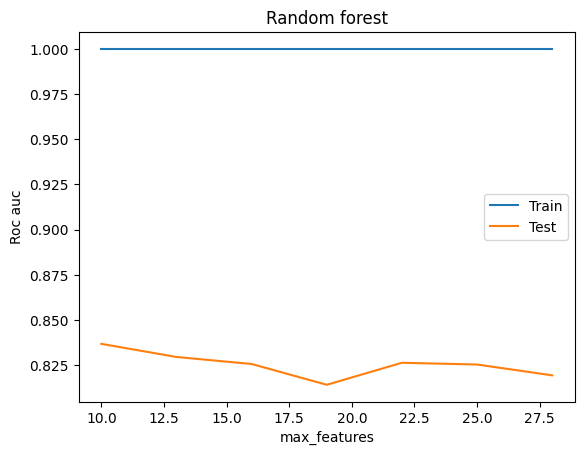

In [59]:
ValidationCurveDisplay.from_estimator(random_forest, X_train, y_train, param_name='max_features', param_range=[i for i in range(10, 30, 3)], std_display_style=None, scoring='roc_auc')
plt.title('Random forest')

Text(0.5, 1.0, 'Arbol de decision')

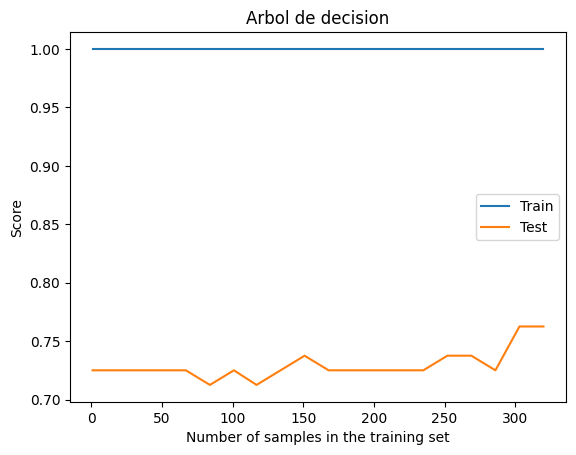

In [61]:
LearningCurveDisplay.from_estimator(random_forest, X_train, y_train, std_display_style=None, train_sizes = np.linspace(0.00001, 1, 20), cv=train_test_indices)
plt.title('Random forest')